In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
'''
References:
-----------

Ben Trevett (2020). PyTorch Seq2Seq. URL: https://github.com/bentrevett/pytorch-seq2seq

Alexander Rush (2018). \The Annotated Transformer". In: Melbourne, Australia: Association for Computational Linguistics, pp. 52{60. doi: 10.18653/v1/W18-2509. URL: https://aclanthology.org/W18-2509

Yu-Hsiang Huang (2019) Attention is all you need: A Pytorch Implementation URL: https://github.com/jadore801120/attention-is-all-you-need-pytorch

TensorFlow (2021). Transformer model for language understanding. URL: https://www.tensorflow.org/text/tutorials/transformer.#
'''

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.legacy.datasets import IWSLT
from torchtext.legacy.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import os
from timeit import default_timer as timer
import numpy as np

import random
import math
import time

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Preprocessing

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.9 MB 31.3 MB/s 
     |████████████████████████████████| 596 kB 47.9 MB/s 
     |████████████████████████████████| 895 kB 55.4 MB/s 
     |████████████████████████████████| 3.3 MB 34.2 MB/s 
     |████████████████████████████████| 56 kB 5.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from transformers import BertTokenizer
bert_tokenizer_en = BertTokenizer.from_pretrained("bert-base-uncased")
bert_tokenizer_de = BertTokenizer.from_pretrained("bert-base-german-cased",do_lower_case=True)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/249k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/474k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

In [ ]:
def tokenize_de(text):
    #Tokenizes German text from a string into a list of strings
    return [tok for tok in bert_tokenizer_de.tokenize(text)]

def tokenize_en(text):
    #Tokenizes English text from a string into a list of strings
    return [tok for tok in bert_tokenizer_en.tokenize(text)]

In [ ]:
MAX_LEN = 100

SRC = Field(tokenize = tokenize_de,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True,
            batch_first = True,
            fix_length=MAX_LEN)

TRG = Field(tokenize = tokenize_en,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True,
            batch_first = True,
            fix_length=MAX_LEN)


#dataset_folder='/home/premyu/dataset/'
dataset_folder='/content/drive/MyDrive/dataset/'
#train_data, valid_data, test_data = IWSLT.splits(exts = ('.de', '.en'), root=dataset_folder, fields = (SRC, TRG))  

train_data, valid_data, test_data = IWSLT.splits(exts = ('.de', '.en'), root=dataset_folder, fields = (SRC, TRG),
                                                 filter_pred=lambda x: len(vars(x)['src']) <= MAX_LEN and len(vars(x)['trg']) <= MAX_LEN)                                              

In [ ]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
BATCH_SIZE = 64

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     device = device)

# Transformer modules

In [ ]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

class PostionalEncoding(nn.Module):
    """
    compute sinusoid encoding.
    """

    def __init__(self, max_len, d_model, device=device):
        """
        constructor of sinusoid encoding class

        :param d_model: dimension of model
        :param max_len: max sequence length
        :param device: hardware device setting
        """
        super(PostionalEncoding, self).__init__()

        # same size with input matrix (for adding with input matrix)
        self.encoding = torch.zeros(max_len, d_model, device=device)
        self.encoding.requires_grad = False  # we don't need to compute gradient

        pos = torch.arange(0, max_len, device=device)
        pos = pos.float().unsqueeze(dim=1)
        # 1D => 2D unsqueeze to represent word's position

        _2i = torch.arange(0, d_model, step=2, device=device).float()
        # 'i' means index of d_model (e.g. embedding size = 50, 'i' = [0,50])
        # "step=2" means 'i' multiplied with two (same with 2 * i)

        self.encoding[:, 0::2] = torch.sin(pos / (10000 ** (_2i / d_model)))
        self.encoding[:, 1::2] = torch.cos(pos / (10000 ** (_2i / d_model)))
        # compute positional encoding to consider positional information of words

    def forward(self, x):
        # self.encoding
        # [max_len = 512, d_model = 512]

        batch_size, seq_len = x.size()
        # [batch_size = 128, seq_len = 30]

        return self.encoding[:seq_len, :]
        # [seq_len = 30, d_model = 512]
        # it will add with tok_emb : [128, 30, 512]


In [ ]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()

        self.device = device
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, src len]
        
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        #src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
            
        #src = [batch size, src len, hid dim]
            
        return src

class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len] 
                
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        return src


class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]
            
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
                
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        
        #output = [batch size, trg len, output dim]
            
        return output, attention

class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        
        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention


class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256
ENC_LAYERS = 8
DEC_LAYERS = 1
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

In [ ]:
enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

In [ ]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 16,827,845 trainable parameters


In [ ]:
class NoamOptimizer():
    '''
    Implements the Noam Learning rate schedule. This corresponds to increasing the learning rate
    linearly for the first ``warmup_steps`` training steps, and decreasing it thereafter proportionally
    to the inverse square root of the step number, scaled by the inverse square root of the
    dimensionality of the model.

    Parameters
    ----------
    warmup_steps: ``int``, required.
        The number of steps to linearly increase the learning rate.
    '''

    def __init__(self, optimizer, lr_mul, d_model, n_warmup_steps):
        self._optimizer = optimizer
        self.lr_mul = lr_mul
        self.d_model = d_model
        self.n_warmup_steps = n_warmup_steps
        self.n_steps = 0


    def step(self):
        "Step with the inner optimizer"
        self._update_learning_rate()
        self._optimizer.step()


    def zero_grad(self):
        "Zero out the gradients with the inner optimizer"
        self._optimizer.zero_grad()


    def _get_lr_scale(self):
        d_model = self.d_model
        n_steps, n_warmup_steps = self.n_steps, self.n_warmup_steps
        return (d_model ** -0.5) * min(n_steps ** (-0.5), n_steps * n_warmup_steps ** (-1.5))


    def _update_learning_rate(self):
        ''' Learning rate scheduling per step '''

        self.n_steps += 1
        lr = self.lr_mul * self._get_lr_scale()

        for param_group in self._optimizer.param_groups:
            param_group['lr'] = lr


#optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, betas=(0.9, 0.98), eps=1e-9)
optimizer = NoamOptimizer(torch.optim.Adam(model.parameters(), lr=0,betas=(0.9, 0.98), eps=1e-09),
                          lr_mul=1, d_model=HID_DIM, n_warmup_steps=20000)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [ ]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += float(loss.item())
        
    return epoch_loss / len(iterator)

In [ ]:
#criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)


def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:,:-1])
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
load_path='/content/drive/MyDrive/iwslt_checkpoint/'
model_checkpoint='model_checkpoint.pt'

In [ ]:
if torch.cuda.is_available():
    model.load_state_dict(torch.load(os.path.join(load_path,model_checkpoint)))
else:
    model.load_state_dict(torch.load(os.path.join(load_path,model_checkpoint),map_location=torch.device('cpu')))

# Inference on test set

In [ ]:
start = timer()
test_loss = evaluate(model, test_iterator, criterion)
end = timer()

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')
print(f'Total inference time: {end - start:.2f} seconds')

| Test Loss: 2.451 | Test PPL:  11.601 |
Total inference time: 50.10 seconds


# Translating candidate sentences

In [ ]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 100):
    
    model.eval()
        
    if isinstance(sentence, str):
        tokens = [token for token in bert_tokenizer_de.tokenize(sentence)]
    else:
        tokens = [token for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        trg_indexes.append(pred_token)
        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

In [ ]:
# Since BERT tokenizer splits the rare words with "##", we can restore the output of the source, target, 
# and predicted sentences to a proper form.

def is_subtoken(word):
    if word[:2] == "##":
        return True
    else:
        return False


def restore(tokens):
    restored_text = []
    for i in range(len(tokens)):
        if not is_subtoken(tokens[i]) and (i+1)<len(tokens) and is_subtoken(tokens[i+1]):
            restored_text.append(tokens[i] + tokens[i+1][2:])
            if (i+2)<len(tokens) and is_subtoken(tokens[i+2]):
                restored_text[-1] = restored_text[-1] + tokens[i+2][2:]
        elif not is_subtoken(tokens[i]):
            restored_text.append(tokens[i])
    return restored_text


def print_restored(text):
    #restored_translation = print(" ".join(str(x) for x in restore(text)))
    restored_translation = " ".join(str(x) for x in restore(text))
    return restored_translation

## Train samples

In [ ]:
example_idx = 8
src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'Source:\n {print_restored(src)}\n')
print(f'Target:\n {print_restored(trg)}\n')
print(f'Predicted target:\n {print_restored(translation)}\n')

Source:
 ein teil des problems ist , dass wir am strand stehen oder bilder wie dieses hier sehen und auf die riesige blaue weite schauen , und sie schimmert und bewegt sich , es gibt wellen , brandung und gezeiten , aber wir haben keine ahnung , was darin verborgen ist .

Target:
 part of the problem , i think , is we stand at the beach , or we see images like this of the ocean , and you look out at this great big blue expanse , and it ' s shimmering and it ' s moving and there ' s waves and there ' s surf and there ' s tides , but you have no idea for what lies in there .

Predicted target:
 part of the problem is that we ' re standing on the beach or seeing images like this , looking at the giant blue , and it ' s room and it ' s moving , there ' s waves , there ' s braille and there ' s no surface , but we have no idea what ' s hidden in it . <eos>



## Test samples

In [ ]:
example_idx = 91
src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'Source:\n {print_restored(src)}\n')
print(f'Target:\n {print_restored(trg)}\n')
print(f'Predicted target:\n {print_restored(translation)}\n')

Source:
 jetzt ist also die zeit fur diesen internationalen job , dieses praktikum , diesen startup , den ihr versuchen wolltet .

Target:
 so now is the time for that cross - country job , that internship , that startup you want to try .

Predicted target:
 so now , the time for this international job , this practice , this week , this starup , which you wanted to try . <eos>



In [ ]:
example_idx = 15
src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'Source:\n {print_restored(src)}\n')
print(f'Target:\n {print_restored(trg)}\n')
print(f'Predicted target:\n {print_restored(translation)}\n')

Source:
 ich sagte : " ja klar , sie trifft sich mit mannern unter ihrem niveau , sie schlaft mit einem schwachkopf , aber sie wird ihn nicht heiraten . "

Target:
 i said , " sure , she ' s dating down , she ' s sleeping with a knuckle , but it ' s not like she ' s going to marry the guy . "

Predicted target:
 and i said , " well , you know , you ' ve got to go to the other side of the wall street , you ' ve got to go to the door . " <eos>



In [ ]:
example_idx = 610
src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'Source:\n {print_restored(src)}\n')
print(f'Target:\n {print_restored(trg)}\n')
print(f'Predicted target:\n {print_restored(translation)}\n')

Source:
 aber dies ist ein modell , was in der zukunft nicht wiederholt werden kann .

Target:
 but it is an irrepro model for the future .

Predicted target:
 but this is a model which can ' t be repeated in the future . <eos>



In [ ]:
del test_data.examples[714]


# 180,201,265,417,714

In [ ]:
vars(test_data.examples[714])

# Calculation BLEU score

In [ ]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 100):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
                
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
    #print(pred_trgs)
    #print(trgs)
        
    return bleu_score(pred_trgs, trgs)

In [ ]:
start = timer()
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)
end = timer()

print(f'BLEU score = {bleu_score*100:.2f}')
print(f'Total inference time: {end - start:.2f} seconds')

BLEU score = 26.04
Total inference time: 239.33 seconds


# Attention Visualisation

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [ ]:
def display_attention(sentence, translation, attention, filename, n_heads = 8, n_rows = 2, n_cols = 4):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(16, 8))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention,cmap='viridis')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=90)
        ax.set_yticklabels(['']+translation)
        ax.set_xlabel(f'Head {i+1}')

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
        #ax.grid()
        
    plt.tight_layout()
    fig.savefig(filename,format='png', dpi=600)
    plt.show()
    
    plt.close()

In [ ]:
example_idx = 630
src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'Source:\n {src}\n')
print(f'Target:\n {trg}\n')
print(f'Predicted target:\n {translation}\n')

Source:
 ['es', 'w', '##inkt', 'dir', 'vom', 'ru', '##cken', 'eines', 'gelb', '-', 'braun', '##en', 'pf', '##er', '##des', 'aus', 'zu', '.']

Target:
 ['cookie', 'monster', 'is', 'waving', 'at', 'you', 'from', 'his', 'perch', 'on', 'top', 'of', 'a', 'tan', 'horse', '.']

Predicted target:
 ['it', "'", 's', 'floating', 'from', 'behind', 'to', 'a', 'yellow', '-', 'brown', 'horse', '.', '<eos>']



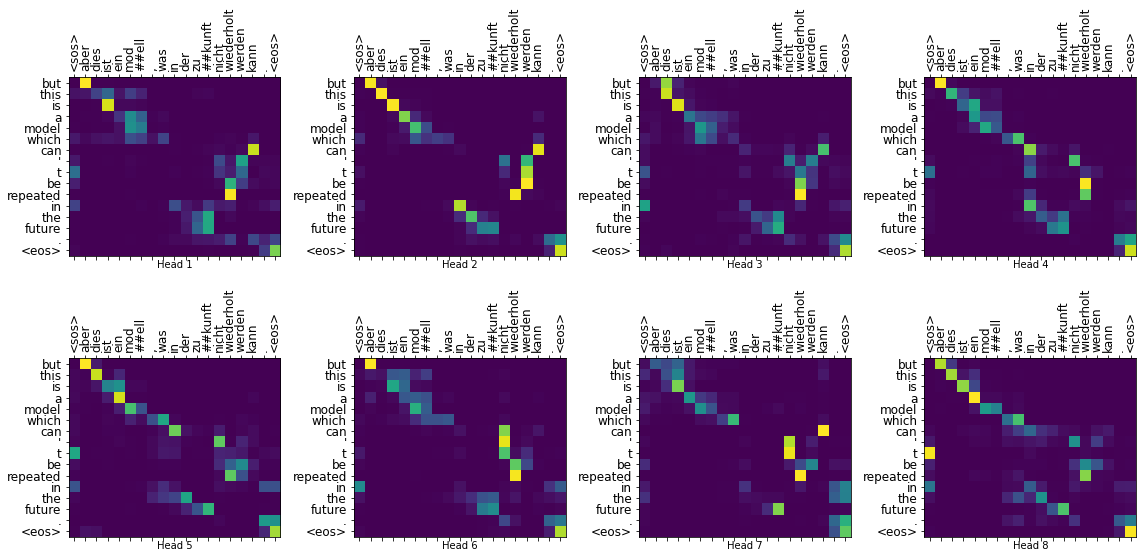

In [ ]:
display_attention(src, translation, attention, '/content/drive/MyDrive/iwslt_checkpoint/iwslt31_attention.png')

In [ ]:
#candidate = 'das ist das Ergebnis meines Modells'
#this is the result of my model
src = ['das', 'ist', 'das', 'Ergebnis', 'meines', 'Modells', '.']
trg = ['this', 'is', 'the', 'result', 'of', 'my', 'model', '.']

translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['that', "'", 's', 'the', '<unk>', 'of', 'my', '<unk>', '.', '<eos>']


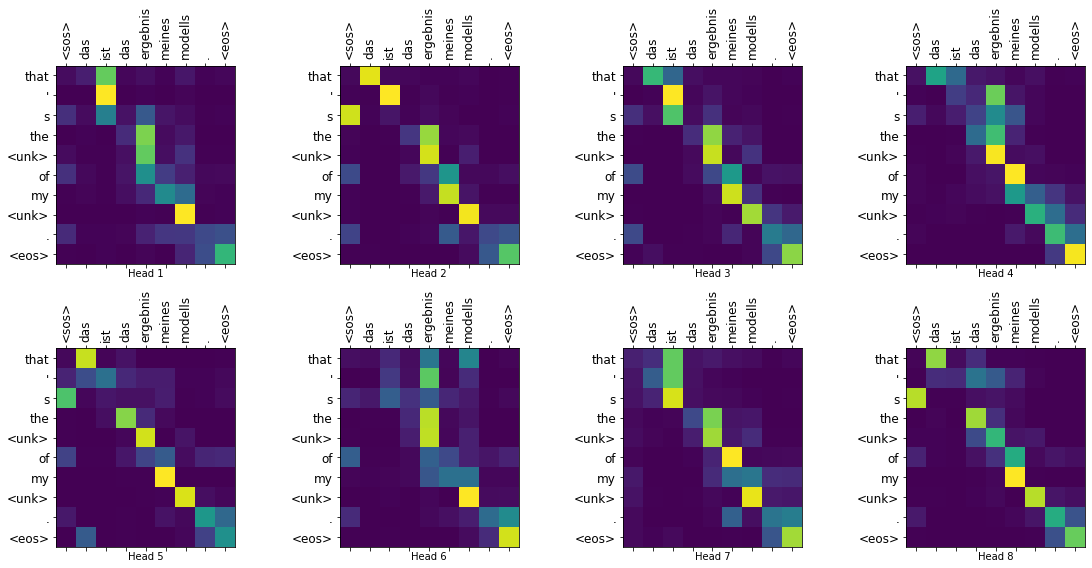

In [ ]:
display_attention(src, translation, attention, '/content/drive/MyDrive/iwslt_checkpoint/candidate_attention.png')

In [ ]:
math.exp(2.512)

12.329564546906333

In [ ]:
candidate= 'wie heißt dein Name?'


tokenized = tokenize_de(candidate) 
print(tokenized)
numericalized = [SRC.vocab.stoi[t] for t in tokenized] 
back_to_candidate = [SRC.vocab.itos[n] for n in numericalized] #need to reverse again as tokenization reverses sentence
print(back_to_candidate)

['wie', 'heißt', 'dein', 'Name', '?']
['wie', 'heißt', 'dein', '<unk>', '?']
